In [37]:
%run Make_Questiones.ipynb
import numpy as np
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import csv

In [38]:
N = 2
#M = 5
I = 2
J = 2
K = 3
Channel_upperbound = 35
Data_upperbound = 20
Processing_upperbound = 35
self_looped = 100

In [39]:
Data_input = Data_Queue(I,J,Data_upperbound)
Data_input_type = Data_Queue_type(I,J,K)
VM_type = VM_Data_type_gen(I,K,N)
VM_speed = VM_Data_processing_speed(Processing_upperbound, VM_type, K)

In [40]:
Channel_link = Create_channel(N,Channel_upperbound,option = "same",initial_length = 1)
print(Channel_link)

[[  0.   1.   1.]
 [  0. 100.  11.]
 [  0.  11. 100.]]


In [41]:
 
print(VM_type)
print(Data_input_type)

[[2 3]
 [1 2]]
[[2 1]
 [3 2]]


In [42]:


VM_DP_time = VM_Data_processing_time(Data_input, Data_input_type , VM_speed)
print(np.shape(VM_DP_time),np.shape( Data_input_type),np.shape(VM_speed))

(2, 2, 2) (2, 2) (2, 3)


In [43]:
VM_DP_time

array([[[ 1.,  1.],
        [inf,  1.]],

       [[ 2., inf],
        [ 1.,  1.]]])

In [44]:
Transmission_time = Channel_Data_transmission_time(Data_input , Channel_link)
np.shape(Transmission_time)


(2, 3, 2, 3)

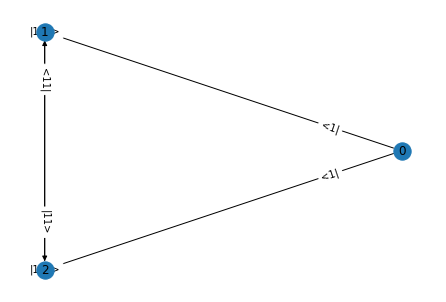

In [45]:
Draw_network(Channel_link)

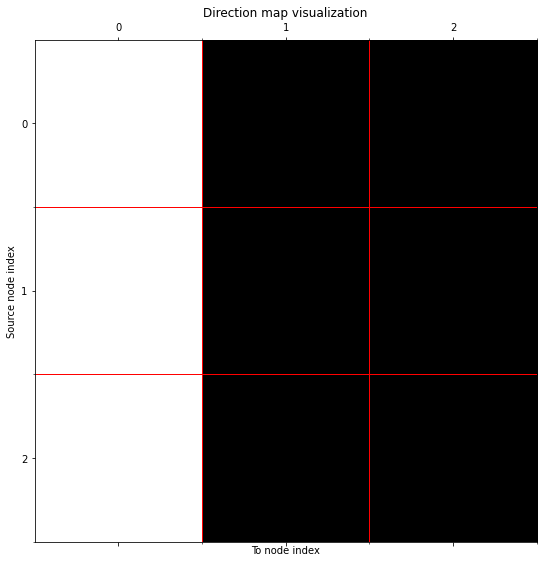

In [46]:
show_relation(np.sign(Channel_link))

In [47]:
next_index,_ = np.where(VM_type==5)
print(next_index)
#print(y_index)

[]


In [48]:
modified_VM_DP_time = VM_DP_time
modified_VM_DP_time[np.isinf(modified_VM_DP_time)]=0
print("每个任务的经过未知机器处理的最大时间")
print(np.max(modified_VM_DP_time[:,:,:],2))
T_max_DP = np.sum(np.max(modified_VM_DP_time[:,:,:],2))
print("Worst case processing T_max 为:", T_max_DP)

每个任务的经过未知机器处理的最大时间
[[1. 1.]
 [2. 1.]]
Worst case processing T_max 为: 5.0


In [49]:
modified_Transmission_time = Transmission_time[:,1:,:,1:]
modified_Transmission_time[np.isinf(modified_Transmission_time)] = 0  #可不做（只要左，上需要从除去inf，除非不是全连接图）
print(np.shape(modified_Transmission_time))
print("每个任务的经过未知link的最大时间")
print(np.max(modified_Transmission_time,(1,3)))

T_max_DT = np.sum(np.max(modified_Transmission_time,(1,3)))

print("Worst case of transmission T_max 为:", T_max_DT)

(2, 2, 2, 2)
每个任务的经过未知link的最大时间
[[1. 1.]
 [2. 2.]]
Worst case of transmission T_max 为: 6.0


In [50]:
T_max = int(T_max_DP + T_max_DT )
print("Worst case of whole DT + DP T_max 为:", T_max)

Worst case of whole DT + DP T_max 为: 11


In [51]:
initial_Transmission_time = Transmission_time[:,1:,:,1:]
T_max = little_greedy_algorithm(VM_DP_time,initial_Transmission_time,I,J,N)
print(T_max)

6


In [52]:
print("let t = 1 unit of time")

let t = 1 unit of time


In [53]:
position_dictionary, Total = Make_dictionary(I,J,N,T_max)
QUBO_init = np.zeros((Total, Total))

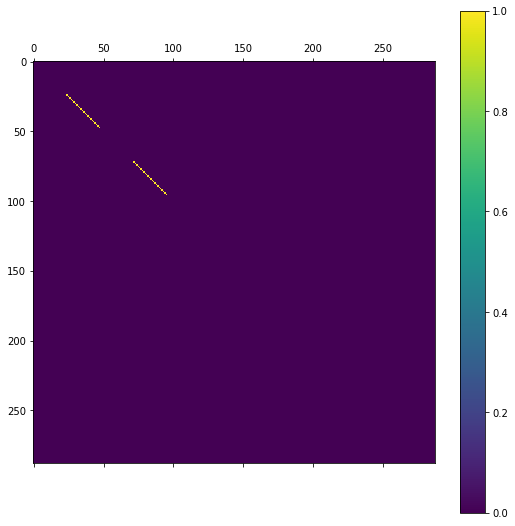

In [54]:
#Obj QUBO dont flatten yet
w = np.zeros((I,J,N,N,T_max))
w[:,J-1,:,:,:] = 1
print()
QUBO_0 = np.zeros_like(QUBO_init)
QUBO_0[:len(w.flatten()),:len(w.flatten())] = np.diag(w.flatten())

#print(QUBO)
show_graph(QUBO_0)

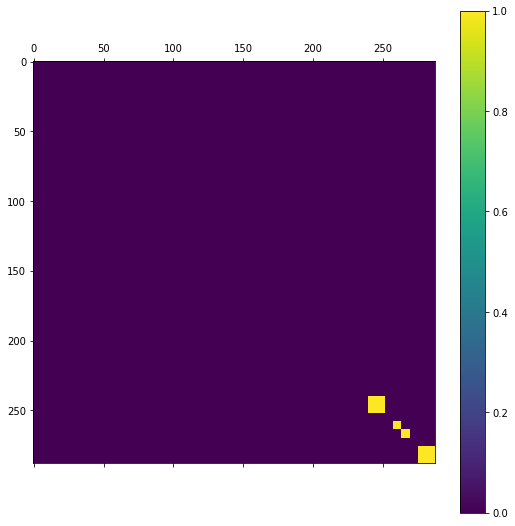

In [55]:
#C1
P1 = np.ones((I,J))
QUBO_1 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        index_matched = [];
        for machine in V_ij_k:
            for t in range(T_max):
                index_matched.append(position_dictionary['z_%d%d%d%d'%(i,j,machine,t)])
        #print(index_matched)
        z_matched = np.zeros(Total)
        z_matched[np.array(index_matched)] = 1
        QUBO_1 += P1[i,j]*np.outer(z_matched,z_matched)

show_graph(QUBO_1)

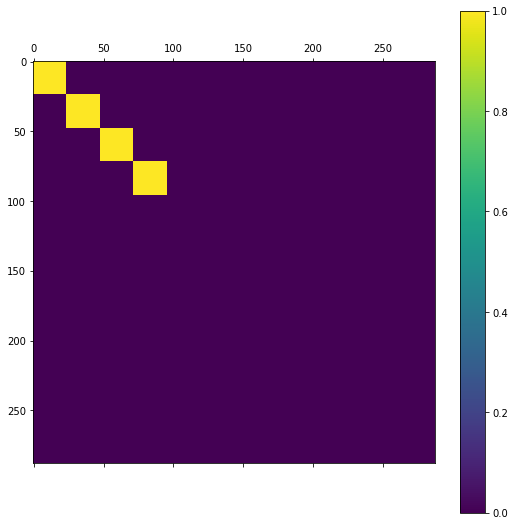

In [56]:
#C2
P2 = np.ones((I,J))
QUBO_2 = np.zeros_like(QUBO_0)

#print(P2)
for i in range(I):
    for j in range(J):
        w = np.zeros((I,J,N,N,T_max))
        w[i,j,:,:,:] = 1    
        QUBO_2[:len(w.flatten()),:len(w.flatten())] += P2[i,j]*np.outer(w.flatten(),w.flatten())
        
show_graph(QUBO_2)

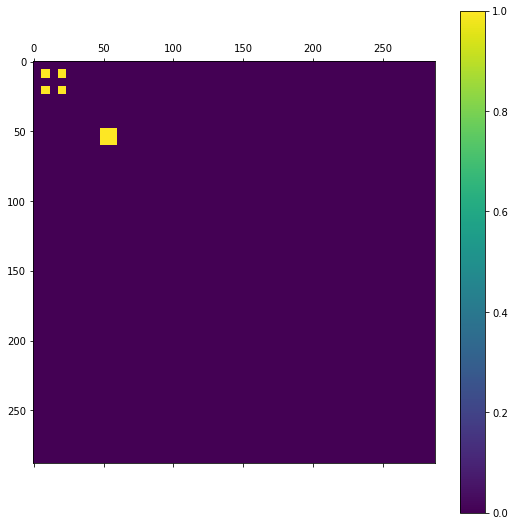

In [57]:
#C3 P 算错了 should be j-1
P3 = np.ones((I,J))
QUBO_3 = np.zeros_like(QUBO_0)

#print(P3)
for i in range(I):
    for j in range(J-1):
        
        w = np.zeros((I,J,N,N,T_max))
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        V_ijplus1_k, _ = np.where(VM_type == Data_input_type[i,j+1])
        for m in V_ij_k:
            for n in V_ijplus1_k:
                w[i,j,m,n,:] = 1    
        QUBO_3[:len(w.flatten()),:len(w.flatten())] += P3[i,j]*np.outer(w.flatten(),w.flatten())

show_graph(QUBO_3)
        
        


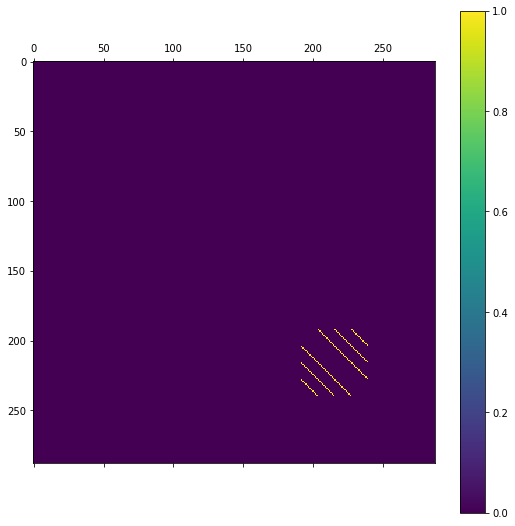

In [58]:
#C4
P4 = np.ones((N,T_max))
QUBO_4 = np.zeros_like(QUBO_init)
for m in range(N):
    for t in range(T_max):
        index_matched = []
        for i in range(I):
            for j in range(J):
                index_matched.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
        #print(index_matched)
        y_matched = np.zeros(Total)
        y_matched[np.array(index_matched)] = 1
        #print(np.sum(y_matched))
        QUBO_4 += P4[m,t]*(np.outer(y_matched,y_matched)-np.diag(y_matched))

show_graph(QUBO_4)        

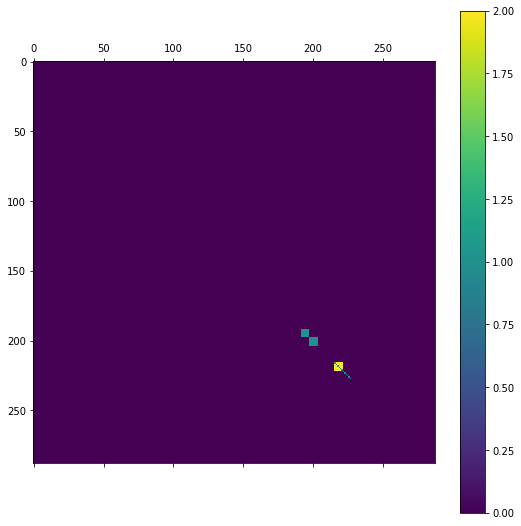

In [59]:
#C6 这个M 有限制？
P6 = np.ones((I,J,N))
QUBO_6 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J-1):
        for m in range(N):
            index_matched = []
            for t in range(T_max):
                index_matched.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
        #print(index_matched)
            y_matched = np.zeros(Total)
            y_matched[np.array(index_matched)] = 1
            QUBO_6 += P6[i,j,m]*(modified_VM_DP_time[i,j,m] * (np.outer(y_matched,y_matched)-np.diag(y_matched))+np.diag(y_matched) )

show_graph(QUBO_6)        

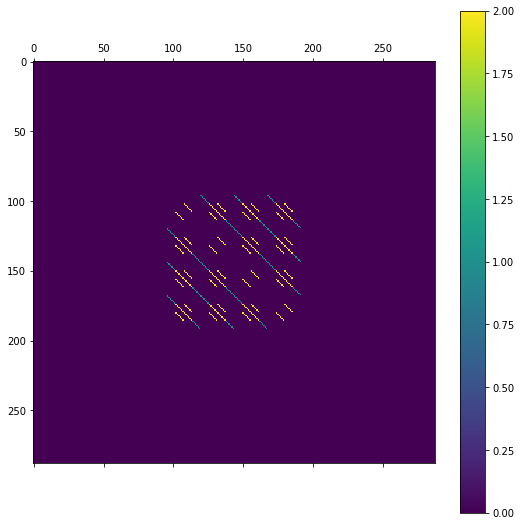

In [60]:
#C9
P9 = np.ones((N,N,T_max))
QUBO_9 = np.zeros_like(QUBO_init)
for m in range(N):
    for n in range(N):
        for t in range(T_max):
            index_matched_term1 = []
            index_matched_term2 = []
            for i in range(I):
                for j in range(J):
                    index_matched_term1.append(position_dictionary['v_%d%d%d%d%d'%(i,j,m,n,t)])
                    index_matched_term2.append(position_dictionary['v_%d%d%d%d%d'%(i,j,n,m,t)])
            # record them down to 2 vectors
            v_matched = np.zeros(Total)
            v_matched[np.array(index_matched_term1)] = 1
            v_matched[np.array(index_matched_term2)] = 1
            # Part1
            QUBO_9 += P9[m,n,t]*(np.outer(v_matched,v_matched)-np.diag(v_matched))

show_graph(QUBO_9)    

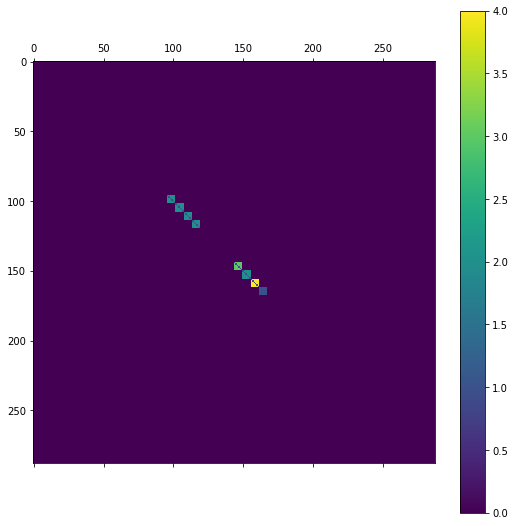

In [61]:
#C11 这个M 有限制？
P11 = np.ones((I,J,N,N))
QUBO_11 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J-1):
        for m in range(N):
            for n in range(N):
                index_matched = []
                for t in range(T_max):
                    index_matched.append(position_dictionary['v_%d%d%d%d%d'%(i,j,m,n,t)])
                #print(index_matched)
                v_matched = np.zeros(Total)
                v_matched[np.array(index_matched)] = 1
                QUBO_11 += P11[i,j,m,n]*(modified_Transmission_time[i,m,j,n] * (np.outer(v_matched,v_matched)-np.diag(v_matched))+np.diag(v_matched) )

show_graph(QUBO_11)        

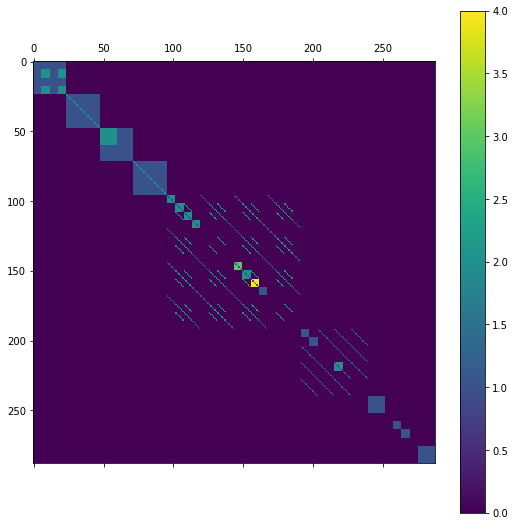

In [62]:
QUBO = np.zeros_like(QUBO_init)
QUBO = QUBO_0 + QUBO_1 + QUBO_2 + QUBO_3 + QUBO_4 + QUBO_6 + QUBO_9 + QUBO_11
show_graph(QUBO) 
position_dictionary, Total = Make_dictionary(I,J,N,T_max)
QUBO_init = np.zeros((Total, Total))
with open('data.csv', 'w') as f:
    for key in position_dictionary.keys():
        f.write("%s, %s\n" % (key, position_dictionary[key]))
Total = len(position_dictionary)


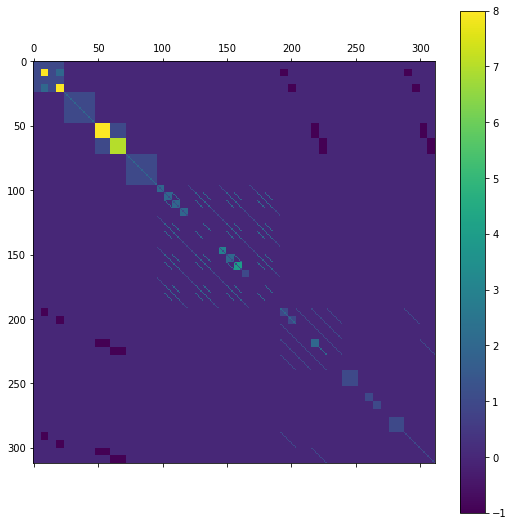

In [63]:
## Single Slack Variable part
#C5
constraint = 5
P5 = np.ones((I,J,N,T_max))
for i in range(I):
    for j in range(J-1):
        for m in range(N):
            for t in range(T_max):
            
                index_matched_y = []
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
                
                index_matched_w = []
                V_ijplus1_k, _ = np.where(VM_type == Data_input_type[i,j+1])
                for n in V_ijplus1_k:
                    for t in range(T_max):
                        index_matched_w.append(position_dictionary['w_%d%d%d%d%d'%(i,j,m,n,t)])
                
                #slack var
                #print(np.shape(QUBO))
                position_dictionary["s_%d_%d%d%d%d"%(constraint,i,j,m,t)] = Total
                Total += 1
                QUBO = np.pad(QUBO, [(0, 1), (0, 1)], mode='constant', constant_values = 0)
                #print(np.shape(QUBO))
                #
                
                #print(len(position_dictionary))
                var_matched = np.zeros(Total)
                var_matched[index_matched_y] = 1
                var_matched[index_matched_w] = -1
                var_matched[-1] = 1
                QUBO += P5[i,j,m,t]*np.outer(var_matched,var_matched)
                
show_graph(QUBO) 

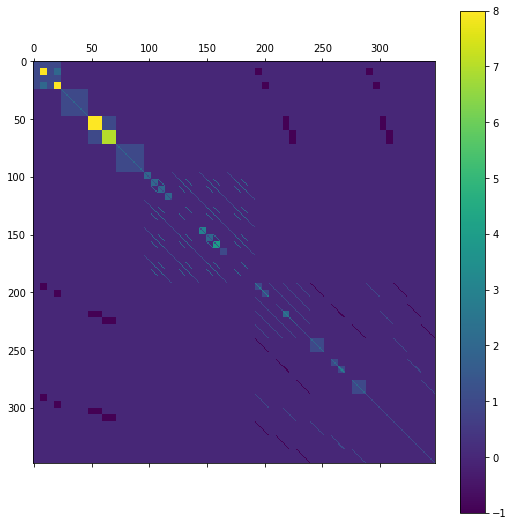

In [64]:
## Single Slack Variable part
#C8
constraint = 8
P8 = np.ones((I,J,N,T_max))
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                index_matched_y = []
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])                
                
                alpha = 0
                index_matched_z = []
                for alpha in range(1,int(modified_VM_DP_time[i,j,m])+1):
                    index_matched_z.append(position_dictionary['z_%d%d%d%d'%(i,j,m,max(t-alpha+1,0))])
                
                #slack var
                #print(np.shape(QUBO))
                if (alpha <= 0):
                    continue
                else:    
                    position_dictionary["s_%d_%d%d%d%d"%(constraint,i,j,m,t)] = Total
                    Total += 1
                    QUBO = np.pad(QUBO, [(0, 1), (0, 1)], mode='constant', constant_values = 0)
                    #print(np.shape(QUBO))
                    #
                
                    #print(len(position_dictionary))
                    var_matched = np.zeros(Total)
                    var_matched[index_matched_y] = -1
                    var_matched[np.unique(index_matched_z)] = 1
                    var_matched[-1] = 1
                    QUBO += P8[i,j,m,t]*np.outer(var_matched,var_matched)
                
show_graph(QUBO) 

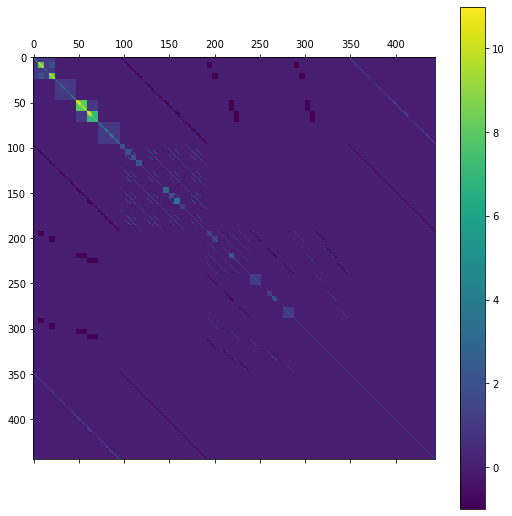

In [65]:
## Single Slack Variable part
#C13
constraint = 13
P13 = np.ones((I,J,N,N,T_max))
for i in range(I):
    for j in range(J):
        for m in range(N):
            for n in range(N):
                for t in range(T_max):
                    index_matched_v = []
                    index_matched_v.append(position_dictionary['v_%d%d%d%d%d'%(i,j,m,n,t)])                
                    
                    alpha = 0
                    index_matched_w = []
                    for alpha in range(1,int(modified_Transmission_time[i,m,j,n])+1):
                        index_matched_w.append(position_dictionary['w_%d%d%d%d%d'%(i,j,m,n,max(t-alpha+1,0))])

                    #slack var
                    #print(np.shape(QUBO))
                    if (alpha <= 0):
                        continue
                    else:    
                        position_dictionary["s_%d_%d%d%d%d%d"%(constraint,i,j,m,n,t)] = Total
                        Total += 1
                        QUBO = np.pad(QUBO, [(0, 1), (0, 1)], mode='constant', constant_values = 0)
                        #print(np.shape(QUBO))
                        #

                        #print(len(position_dictionary))
                        var_matched = np.zeros(Total)
                        var_matched[index_matched_v] = -1
                        var_matched[np.unique(index_matched_w)] = 1
                        var_matched[-1] = 1
                        QUBO += P13[i,j,m,n,t]*np.outer(var_matched,var_matched)
                
show_graph(QUBO) 

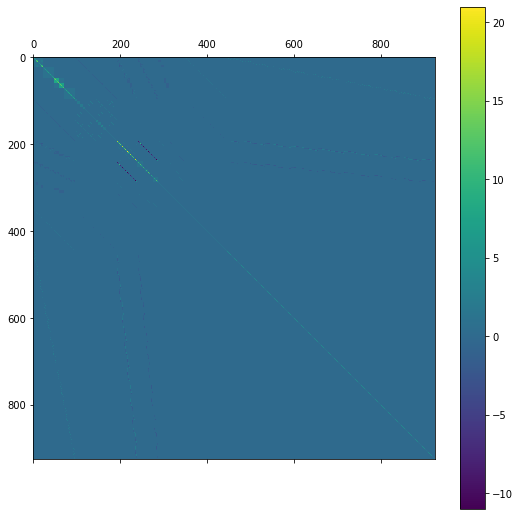

In [66]:
## Double Slack Variable part
#C7
constraint = 7
P7 = np.ones((I,J,N,N,T_max,T_max))
for i in range(I):
    for j in range(J):
        for m in range(N):
            for n in range(N):
                for t in range(1,T_max):
                    for beta in range(T_max-t):
                        index_matched_w = position_dictionary['w_%d%d%d%d%d'%(i,j,m,n,t+beta)]
                        index_matched_y1 = position_dictionary['y_%d%d%d%d'%(i,j,m,t-1)]
                        index_matched_y2 = position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                        index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                        
                        position_dictionary["s_%d_%d%d%d%d%d"%(constraint,i,j,m,n,t)] = Total
                        Total += 2
                        QUBO = np.pad(QUBO, [(0, 2), (0, 2)], mode='constant', constant_values = 0)
                        
                        var_matched = np.zeros(Total)
                        var_matched[index_matched_w] = 1
                        var_matched[index_matched_y1] = -1
                        var_matched[index_matched_y2] = 1
                        var_matched[index_matched_z] = -1
                        var_matched[-2] = 1
                        var_matched[-1] = 2
                        
                        QUBO += P7[i,j,m,n,t,beta]*np.outer(var_matched,var_matched)
                        
show_graph(QUBO)                         

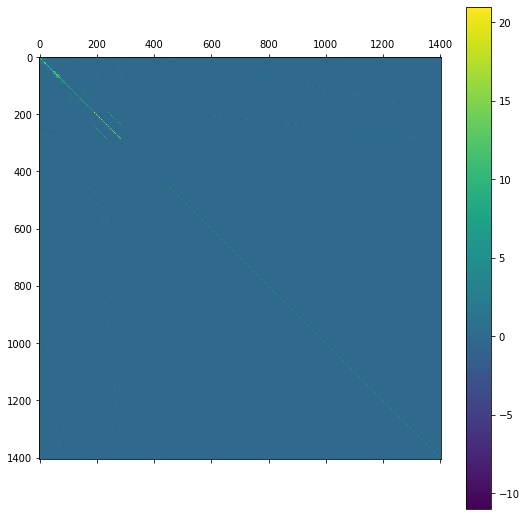

In [67]:
## Double Slack Variable part
#C12
constraint = 12
P12 = np.ones((I,J,N,N,T_max,T_max))
for i in range(I):
    for j in range(J):
        for m in range(N):
            for n in range(N):
                for t in range(1,T_max):
                    for beta in range(T_max-t):
                        index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j,m,t+beta)]
                        index_matched_v1 = position_dictionary['v_%d%d%d%d%d'%(i,j,m,n,t-1)]
                        index_matched_v2 = position_dictionary['v_%d%d%d%d%d'%(i,j,m,n,t)]
                        index_matched_w = position_dictionary['w_%d%d%d%d%d'%(i,j,m,n,t)]
                        
                        position_dictionary["s_%d_%d%d%d%d%d"%(constraint,i,j,m,n,t)] = Total
                        Total += 2
                        QUBO = np.pad(QUBO, [(0, 2), (0, 2)], mode='constant', constant_values = 0)
                        
                        var_matched = np.zeros(Total)
                        var_matched[index_matched_z] = 1
                        var_matched[index_matched_v1] = -1
                        var_matched[index_matched_v2] = 1
                        var_matched[index_matched_w] = -1
                        var_matched[-2] = 1
                        var_matched[-1] = 2
                        
                        QUBO += P12[i,j,m,n,t,beta]*np.outer(var_matched,var_matched)

show_graph(QUBO) 

In [68]:
width,height = np.shape(QUBO)

In [69]:
np.shape(np.array([[1],[2]]))

(2, 1)

In [70]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import numpy as np

import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt
        

In [71]:
#from dwave.system import LeapHybridSampler


QUBO_dictionary = defaultdict(int)
for i in range(width):
    for j in range(height):
        QUBO_dictionary[(i,j)] = QUBO[i,j]

# Select a solver
#sampler = LeapHybridSampler()



# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 8
numruns = 3  #Max =1e4 , a Complex problem needs more numruns 

#response = sampler.sample_qubo(QUBO)

#sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}))
#response = sampler.sample_qubo(QUBO_dictionary, chain_strength=chainstrength, num_reads=numruns)

In [72]:
import hybrid
import dimod
workflow = hybrid.Loop(
   hybrid.RacingBranches(
      hybrid.InterruptableTabuSampler(),
      hybrid.EnergyImpactDecomposer(size=30, rolling=True, rolling_history=0.75)
      | hybrid.QPUSubproblemAutoEmbeddingSampler()
      | hybrid.SplatComposer()) | hybrid.ArgMin(), convergence=3)
bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
result = hybrid.HybridSampler(workflow).sample(bqm)  

In [74]:
#print("Solution: sample={}".format(result.first)) 

In [77]:
import dwave.inspector
from dwave.system.composites import LazyFixedEmbeddingComposite
chainstrength = 4

sampler = LazyFixedEmbeddingComposite(DWaveSampler())

num_reads = 1000
sampleset = sampler.sample_qubo(QUBO, chain_strength=chainstrength, num_reads=num_reads)

ValueError: no embedding found

In [75]:
QUBO_dictionary

defaultdict(int,
            {(0, 0): 7.0,
             (0, 1): 6.0,
             (0, 2): 6.0,
             (0, 3): 6.0,
             (0, 4): 6.0,
             (0, 5): 1.0,
             (0, 6): 1.0,
             (0, 7): 1.0,
             (0, 8): 1.0,
             (0, 9): 1.0,
             (0, 10): 1.0,
             (0, 11): 1.0,
             (0, 12): 1.0,
             (0, 13): 1.0,
             (0, 14): 1.0,
             (0, 15): 1.0,
             (0, 16): 1.0,
             (0, 17): 1.0,
             (0, 18): 1.0,
             (0, 19): 1.0,
             (0, 20): 0.0,
             (0, 21): 0.0,
             (0, 22): 0.0,
             (0, 23): 0.0,
             (0, 24): 0.0,
             (0, 25): 0.0,
             (0, 26): 0.0,
             (0, 27): 0.0,
             (0, 28): 0.0,
             (0, 29): 0.0,
             (0, 30): 0.0,
             (0, 31): 0.0,
             (0, 32): 0.0,
             (0, 33): 0.0,
             (0, 34): 0.0,
             (0, 35): 0.0,
             (0, 36):

In [ ]:
## Retrieve QPU timing data
print(response.info["timing"]) 

## Retrieve Energy data  
energies = iter(response.data())

In [ ]:
print(response.info) 

In [ ]:
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for rank, line in enumerate(response):
    # 2.
    S0_alt = ""
    for k,v in line.items():
        S0_alt += str(v)
    #print(type(v)) 
    E = next(energies).energy
  
    # 2. Binary representation: Example 5 vertices: '11000' --> -15 15
    print('{:>15s} --> {:^15s}{:^15s}'.format(str(rank),str(E),str(int(-1*E))))
    
    # only show lowest x(x = 20) enegy values and their combinations.
    if rank > 20:
        break